# **Importing the Libraries and Reading the Dataset**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.spatial import Voronoi, voronoi_plot_2d

np.set_printoptions(suppress=True)

In [2]:
X = np.genfromtxt("Dataset.csv",delimiter=',')
X = X.T #making the shape dxn as used in class

# **Q1 - Principal Component Analysis** 

### **Q1 (i)**

In [192]:
def get_pc(X):
    '''Returns the principal components and associated eigenvalues and shows some statistics
    Shape of X: (d,n)'''
    n = X.shape[1]
    C = X@(X.T)/n

    print("Mean of the Data:",X.mean(axis=1))

    X_deviations = np.linalg.norm(X-X.mean(axis=1).reshape(-1,1),axis=0)
    var_data = (X_deviations**2).mean() #Variance of the data where the deviation metric is an L2 Norm
    print("Variance of the datapoints:",var_data)    

    w,V = np.linalg.eig(C)
    pcs = V[:,np.flip(w.argsort())]

    w1 = pcs[:,0:1]
    w2 = pcs[:,1:2]

    var1 = ((w1.T)@C@w1)[0][0]
    var2 = ((w2.T)@C@w2)[0][0]
    print("Principal Component 1:\n",w1)
    print("Principal Component 2:\n",w2)

    print()
    print("Variance by pc1:",var1)
    print("Variance by pc1:",var2)
    print("% of variance explained by principal component 1: {0:.2f}%".format(var1/(var1+var2)*100))
    print("% of variance explained by principal component 2: {0:.2f}%".format(var2/(var1+var2) *100))

    print()
    error_pc1 = np.linalg.norm(X-(w1.T@X)*w1,axis=0).mean()
    print("L2 Error considering only pc1:{0:.10f}".format(error_pc1))
    error_pc12 = np.linalg.norm(X-(w1.T@X)*w1-(w2.T@X)*w2,axis=0).mean()
    print("L2 Error considering both pc1 and pc2:{0:.10f}".format(error_pc12))
    return w,pcs

In [256]:
def show_scatter_PC(X,V,title='',pc_scale=5):
    fig = go.Figure(data=[go.Scatter(x=X[0,:],y=X[1,:],mode="markers",name='Datapoints'),
                        go.Scatter(x=[0,pc_scale*V[0,0]],y=[0,pc_scale*V[1,0]],name='Principal Component 1'),
                        go.Scatter(x=[0,pc_scale*V[0,1]],y=[0,pc_scale*V[1,1]],name="Principal Component 2")])
    fig.update_layout(title=title,title_x=0.5,
                      xaxis_title="dim1",
                      yaxis_title="dim2",
                      yaxis=dict(scaleanchor="x", scaleratio=1))
    fig.show()

def show_scatter_data(X,title=''):
    fig = go.Figure(data=[go.Scatter(x=X[0,:],y=X[1,:],mode="markers",name='Datapoints')])
    fig.update_layout(title=title,title_x=0.5,
                      xaxis_title="component 1",
                      yaxis_title="component 2",
                      yaxis=dict(scaleanchor="x", scaleratio=1))
    fig.show()

In [193]:
X_centered = X-X.mean(axis=1).reshape(-1,1) #Centering the Data
w_centered,pc_centered = get_pc(X_centered)

Mean of the Data: [0. 0.]
Variance of the datapoints: 31.621519151775004
Principal Component 1:
 [[-0.323516 ]
 [-0.9462227]]
Principal Component 2:
 [[-0.9462227]
 [ 0.323516 ]]

Variance by pc1: 17.13191440244436
Variance by pc1: 14.489604749330637
% of variance explained by principal component 1: 54.18%
% of variance explained by principal component 2: 45.82%

L2 Error considering only pc1:2.9030077367
L2 Error considering both pc1 and pc2:0.0000000000


In [255]:
show_scatter_PC(X_centered,pc_centered,title="The Data with Principal Components")

### **Q1 (ii)**

Studying the Effects of Centering

In [20]:
w,pc = get_pc(X)

Mean of the Data: [0.00000041 0.00000022]
Variance of the datapoints: 31.621519151775004

Variance by pc1: 17.13191440244448
Variance by pc1: 14.48960474933074
% of variance explained by principle component 1: 54.18%
% of variance explained by principle component 2: 45.82%

L2 Error considering only pc1:2.9030077417
L2 Error considering both pc1 and pc2:0.0000000000


- There is a slight increase in the L2 error (when considering only 1 principal component):<br/>
For Centered Data: 2.9030077367<br/>
For Non-Centered Data: 2.9030077417

-  The given data already seems to be centered to a precision of 10^-6 due to which there are hardly any changes after performing centering

#### Creating a Non-Centered data to Study the effects of PCA on it

In [22]:
X_noncentered = X+4 #adding 4 to each component and entry
w_noncentered,pc_noncentered = get_pc(X_noncentered)

Mean of the Data: [4.00000041 4.00000022]
Variance of the datapoints: 31.621519151775004

Variance by pc1: 48.65205131509879
Variance by pc1: 14.96947287827644
% of variance explained by principal component 1: 76.47%
% of variance explained by principal component 2: 23.53%

L2 Error considering only pc1:2.9362356470
L2 Error considering both pc1 and pc2:0.0000000000


In [23]:
show_scatter_PC(X_noncentered,pc_noncentered,pc_scale=10)

- The L2 Error for noncentered data increases (when considering 1 pc) from 2.903 to 2.9362
- Therefore, it can be concluded that centering the data is essential for PCA and it decreases the error when the data is reconstructed. However, the effects are not noticable in the given data since it is already centered to a precision of 10^-6 

### **Q1 (iii) - Kernel PCA**


In [3]:
def poly_kernel(xi,xj,d):
    return (1+xi.T@xj)**d

def rbf_kernel(xi,xj,sigma):
    return np.exp(-((xi-xj).T)@(xi-xj)/(2*sigma*sigma))

def get_kernel_components_poly(X,d,num_components=2):
    '''It returns the components using polynomial kernel'''
    n = X.shape[1]
    one_N = np.ones((n,n))/n
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            xi = X[:,i]
            xj = X[:,j]
            K[i,j] = poly_kernel(xi,xj,d)

    Kc = K - one_N@K - K@one_N + one_N@K@one_N
    w,V = np.linalg.eig(Kc)
    w=w.real #imaginary part is negligible and real symmetric matrices have only real eigen values
    V = V.real
    alphak = V[:,np.flip(w.argsort())]
    alphak = alphak/((np.abs(w))**0.5)
    kernel_comps = (Kc.T@(alphak[:,0:num_components])).T

    return kernel_comps

def get_kernel_components_rbf(X,sigma,num_components=2):
    '''It returns the components using rbf kernel'''
    n = X.shape[1]
    one_N = np.ones((n,n))/n
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            xi = X[:,i]
            xj = X[:,j]
            K[i,j] = rbf_kernel(xi,xj,sigma)

    Kc = K - one_N@K - K@one_N + one_N@K@one_N
    w,V = np.linalg.eig(Kc)
    w=w.real #imaginary part is negligible and real symmetric matrices have only real eigen values
    V = V.real
    alphak = V[:,np.flip(w.argsort())]
    alphak = alphak/((np.abs(w))**0.5)
    kernel_comps = (Kc.T@(alphak[:,0:num_components])).T

    return kernel_comps

#### **Kernel A: Polynomial Kernel**

In [26]:
kernel_comps = get_kernel_components_poly(X,d=2,num_components=2)
show_scatter_data(kernel_comps,title="Kernel PCA with Polynomial Kernel of d = 2 ")

In [30]:
kernel_comps = get_kernel_components_poly(X,d=3,num_components=2)
show_scatter_data(kernel_comps,title="Kernel PCA with Polynomial Kernel of d = 3")

#### **Kernel B: Radial Basis Function Kernel**

X axis: Component 1 obtained by kernel PCA
Y axis: Component 2 obtained by kernel PCA


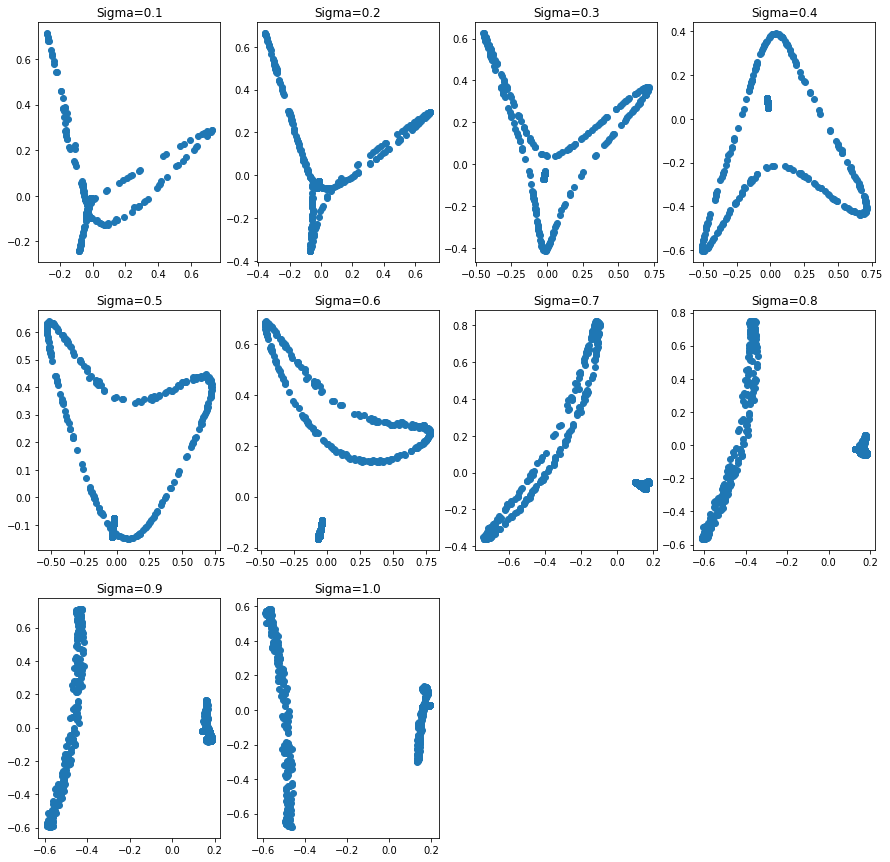

In [31]:
plt.figure(figsize=(15,15))
i=1

print("X axis: Component 1 obtained by kernel PCA")
print("Y axis: Component 2 obtained by kernel PCA")
for sigma in np.linspace(0.1,1,10):
    plt.subplot(3,4,i)
    sigma = round(sigma,2)
    kernel_comps = get_kernel_components_rbf(X,sigma,num_components=2)
    plt.scatter(kernel_comps[0],kernel_comps[1])
    plt.title("Sigma={}".format(sigma))
    i+=1

X axis: Component 1 obtained by kernel PCA
Y axis: Component 2 obtained by kernel PCA


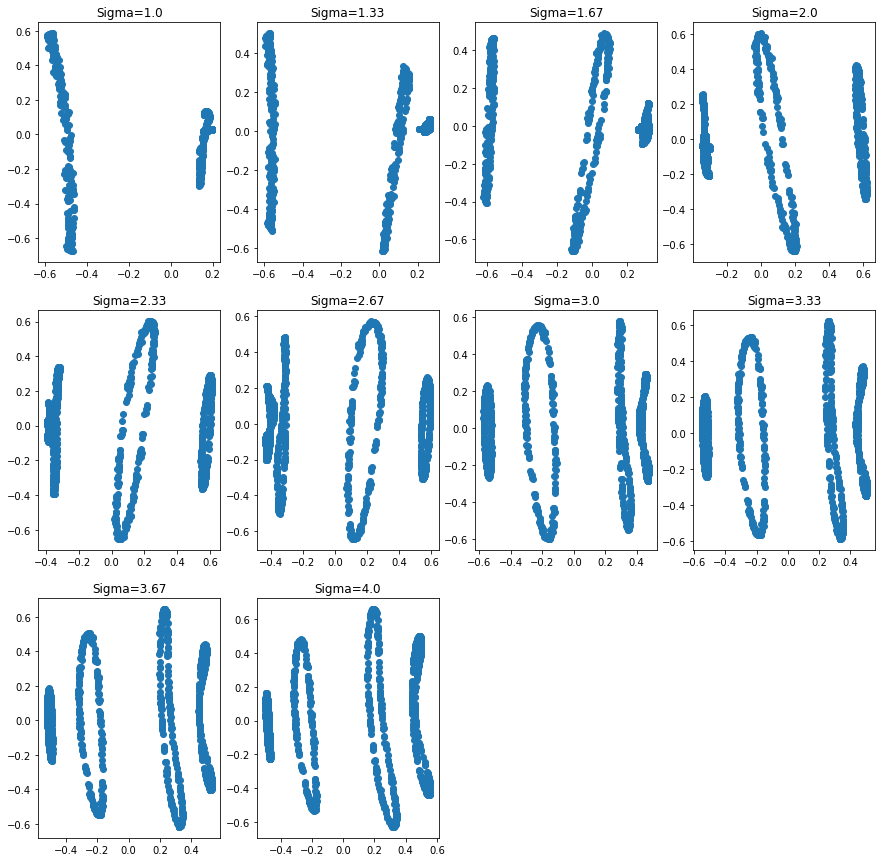

In [200]:
plt.figure(figsize=(15,15))
i=1

print("X axis: Component 1 obtained by kernel PCA")
print("Y axis: Component 2 obtained by kernel PCA")
for sigma in np.linspace(1,4,10):
    plt.subplot(3,4,i)
    sigma = round(sigma,2)
    kernel_comps = get_kernel_components_rbf(X,sigma,num_components=2)
    plt.scatter(kernel_comps[0],kernel_comps[1])
    plt.title("Sigma={}".format(sigma))
    i+=1

- PCA with kernel B i.e radial basis function is a better choice since it seems to divide the dataset into linearly seperable regions. 

# **Q2 - Clustering**

### **Q2 (i)**

In [4]:
def run_llyods(X,K,mu_i=None,max_iter=1000):
    #Parameters: Data, Number of Clusters, Initialised Means (Optional), maximum number of iterations (optional)
    #Returns the initialised means used,Final Means and Assignment Vector 
    n = X.shape[1]
    Z = np.zeros(n,dtype=np.uint8)
    error_history = []
    tolerance = 1

    #get k mu's, initialisation step
    if mu_i is None:
        mu_i = X[:,np.random.randint(0,X.shape[1],K)] #if no initial mu is passed, it is randomly chosen
    else:
        pass

    mu = mu_i.copy()

    for iter in range(max_iter):

        #finding error
        error=0
        for i in range(n):
            error_term = ((X[:,i]-mu[:,Z[i]])**2).sum()
            error += error_term

        error_history.append(error)

        # reassignment step
        for i in range(n):
            xi = X[:,i:i+1]
            Z[i] = np.argmin(((xi-mu)**2).sum(axis=0))

        # Finding Means
        k=0
        for k in range(K):
            if (Z==k).sum()!=0:
                mu[:,k] = (X*((Z==k).reshape(1,1000))).sum(axis=1)/(Z==k).sum()


        if iter>2:
            if abs(error_history[-1]-error_history[-2])<tolerance:
                print("Number of Iterations Taken to Converge:",iter)
                break
    else:
        print("Not Converged. Maximum Number of Iteration Reached!")

    return mu_i,mu,Z,error_history

def display_results(X,mu_i,mu,Z,history):
    plt.figure(figsize=(21,7))

    plt.subplot(1,3,1)
    #fig1 = plt.figure()
    #fig1.set_size_inches(5, 5)
    plt.scatter(X[0],X[1])
    plt.scatter(mu_i[0],mu_i[1],color='r')
    plt.xlabel("dimension 1 of the Data")
    plt.ylabel("dimension 2 of the Data")
    plt.title("Data with Initialised Means")
    plt.legend(["Given Data","Initialised Means"],loc="best")

    plt.subplot(1,3,2)
    #fig2 = plt.figure()
    #ig2.set_size_inches(5, 5)
    plt.scatter(X[0],X[1],c=Z)
    plt.scatter(mu[0],mu[1],color='r')
    plt.xlabel("dimension 1 of the Data")
    plt.ylabel("dimension 2 of the Data")
    plt.title("Clustered Data with Number of Clusters = 4")
    plt.legend(["Clustered Data","Final Means"])
        
    plt.subplot(1,3,3)
    plt.plot(history)
    plt.xlabel("Iteration Number")
    plt.ylabel("Error")
    plt.title("Error vs Iteration")
    
    
    plt.show()

#### **Random Initialisation 1**

Number of Iterations Taken to Converge: 44


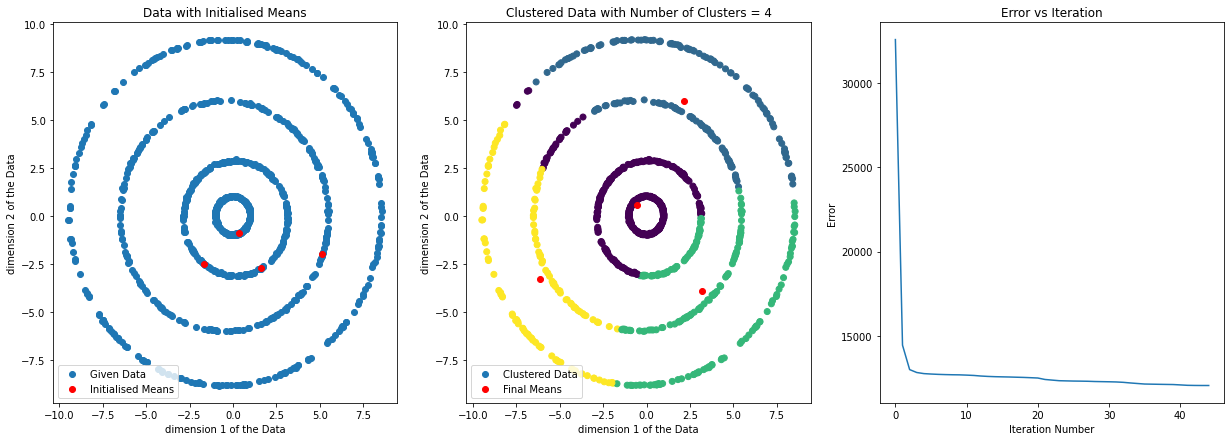

In [8]:
mu_i,mu,Z,history = run_llyods(X_centered,K=4,max_iter=1000)
display_results(X_centered,mu_i,mu,Z,history)

#### **Random Initialisation 2**

Number of Iterations Taken to Converge: 8


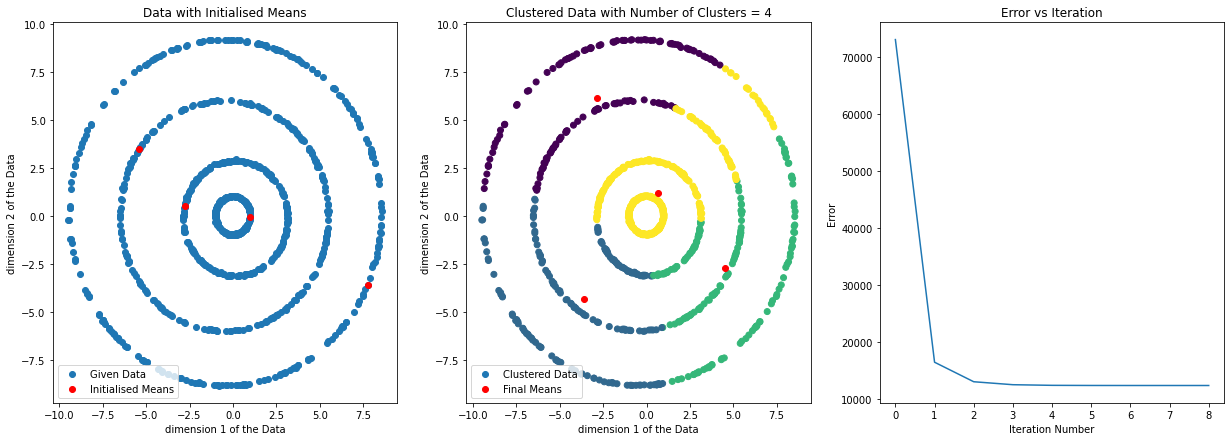

In [9]:
mu_i,mu,Z,history = run_llyods(X_centered,K=4,max_iter=1000)
display_results(X_centered,mu_i,mu,Z,history)

#### **Random Initialisation 3**

Number of Iterations Taken to Converge: 19


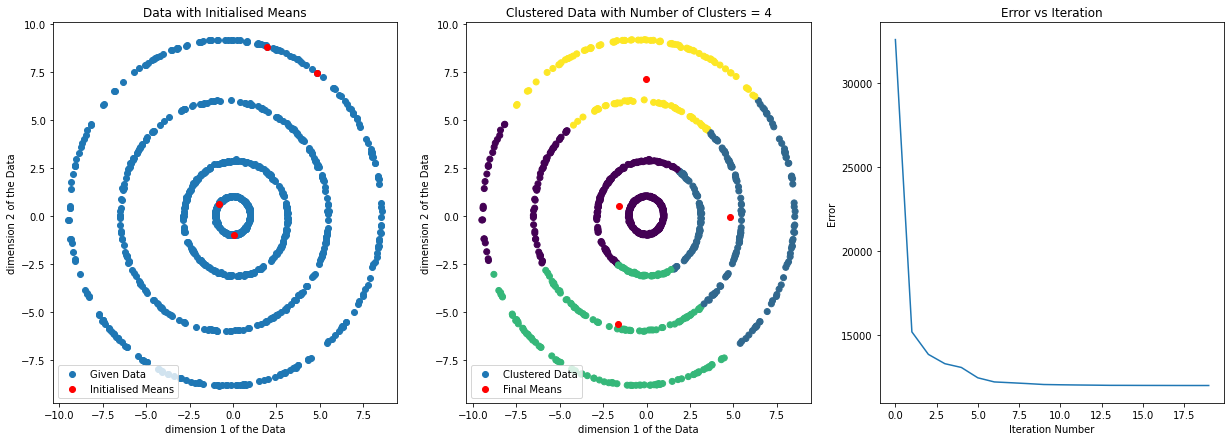

In [10]:
mu_i,mu,Z,history = run_llyods(X_centered,K=4,max_iter=1000)
display_results(X_centered,mu_i,mu,Z,history)

#### **Random Initialisation 4**

Number of Iterations Taken to Converge: 5


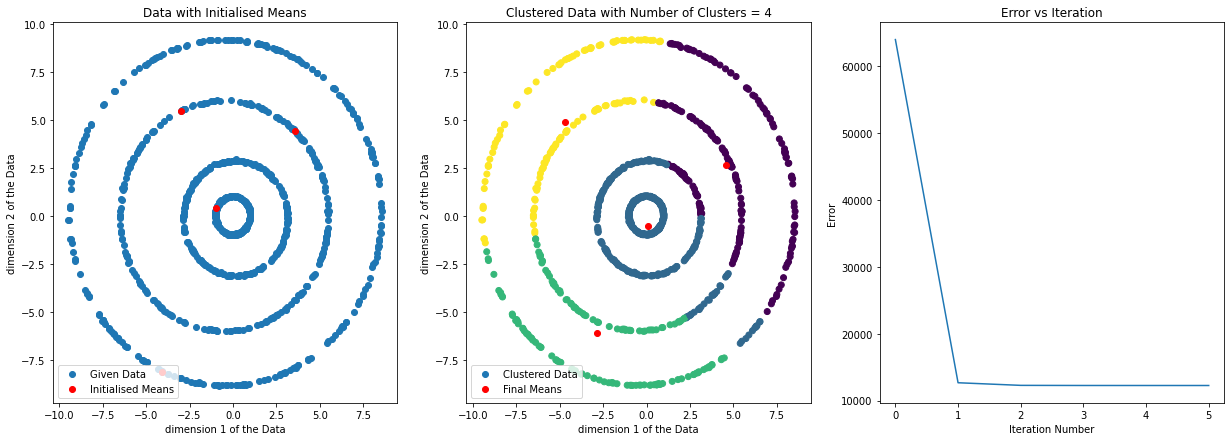

In [11]:
mu_i,mu,Z,history = run_llyods(X_centered,K=4,max_iter=1000)
display_results(X_centered,mu_i,mu,Z,history)

#### **Random Initialisation 5**

Number of Iterations Taken to Converge: 9


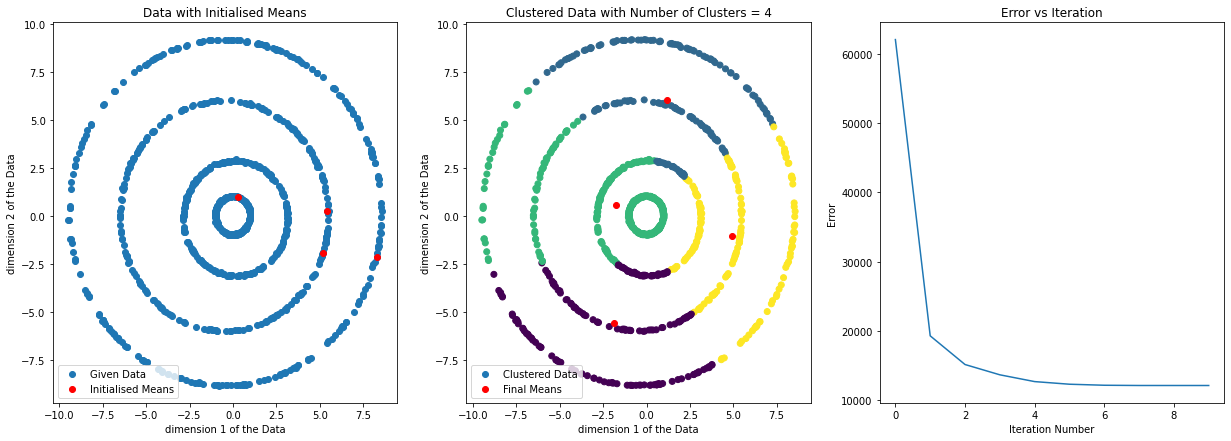

In [12]:
mu_i,mu,Z,history = run_llyods(X_centered,K=4,max_iter=1000)
display_results(X_centered,mu_i,mu,Z,history)

### **Q2 ii.**

In [17]:
tol = 3
xlim_data = (min(X[0])-tol,max(X[0])+tol)
ylim_data = (min(X[1])-tol,max(X[1])+tol)

In [18]:
mu_random = X[:,np.random.randint(0,X.shape[1],5)] #Fixing a random initialisation for mu

#### **K=2**

Number of Iterations Taken to Converge: 23


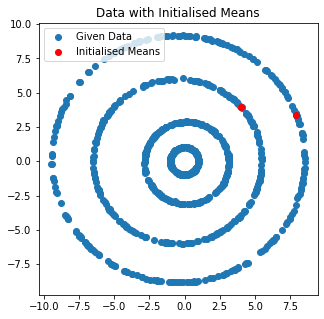

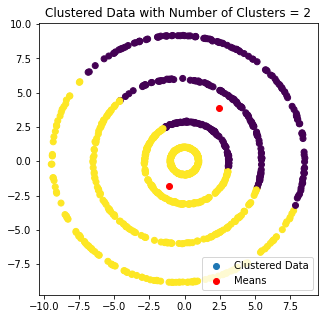

In [19]:
K = 2
mu_i = mu_random[:,:K]

mu_i,mu,Z,_ = run_llyods(X,K=K,mu_i = mu_i)

fig1 = plt.figure()
fig1.set_size_inches(5, 5)
plt.scatter(X[0],X[1])
plt.scatter(mu_i[0],mu_i[1],color='r')
#plt.xlim(*xlim_data)
#plt.ylim(*ylim_data)
plt.title("Data with Initialised Means")
plt.legend(["Given Data","Initialised Means"],loc="best")

#vor = Voronoi(mu.T)
#fig = voronoi_plot_2d(vor,show_points=True,show_vertices=False)
fig2 = plt.figure()
fig2.set_size_inches(5, 5)
plt.scatter(X[0],X[1],c=Z)
plt.scatter(mu[0],mu[1],color='r')
#plt.xlim(*xlim_data)
#plt.ylim(*ylim_data)
plt.title("Clustered Data with Number of Clusters = 2")
plt.legend(["Clustered Data","Means"])

plt.show()

#### **K=3**

Number of Iterations Taken to Converge: 10


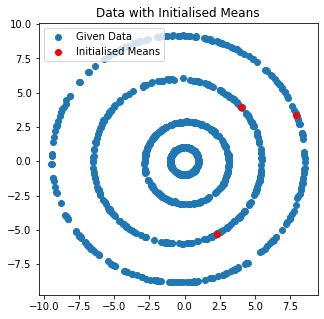

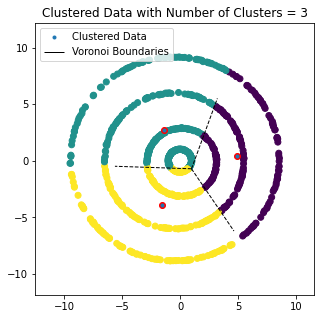

In [20]:
K = 3
mu_i = mu_random[:,:K]

_,mu,Z,_ = run_llyods(X,K=K,mu_i = mu_i)

fig1 = plt.figure()
fig1.set_size_inches(5, 5)
plt.scatter(X[0],X[1])
plt.scatter(mu_i[0],mu_i[1],color='r')
#plt.xlim(*xlim_data)
#plt.ylim(*ylim_data)
plt.title("Data with Initialised Means")
plt.legend(["Given Data","Initialised Means"],loc="best")

vor = Voronoi(mu.T)
fig2=voronoi_plot_2d(vor,show_points=True,show_vertices=False)
fig2.set_size_inches(5,5)
plt.scatter(X[0],X[1],c=Z)
plt.scatter(mu[0],mu[1],color='r')
plt.xlim(*xlim_data)
plt.ylim(*ylim_data)
plt.title("Clustered Data with Number of Clusters = 3")
plt.legend(["Clustered Data","Voronoi Boundaries"])

plt.show()

#### **K=4**

Number of Iterations Taken to Converge: 8


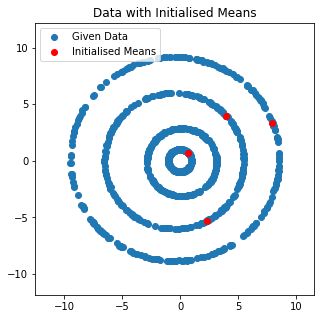

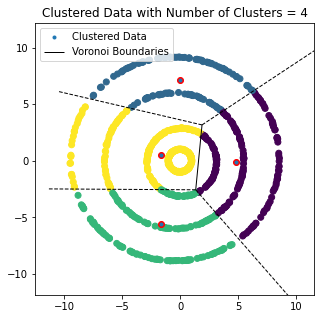

In [21]:
K = 4
mu_i = mu_random[:,:K]

_,mu,Z,_ = run_llyods(X,K=K,mu_i = mu_i)

fig1 = plt.figure()
fig1.set_size_inches(5, 5)
plt.scatter(X[0],X[1])
plt.scatter(mu_i[0],mu_i[1],color='r')
plt.xlim(*xlim_data)
plt.ylim(*ylim_data)
plt.title("Data with Initialised Means")
plt.legend(["Given Data","Initialised Means"],loc="best")

vor = Voronoi(mu.T)
fig2= voronoi_plot_2d(vor,show_points=True,show_vertices=False)
fig2.set_size_inches(5, 5)
plt.scatter(X[0],X[1],c=Z)
plt.scatter(mu[0],mu[1],color='r')
plt.xlim(*xlim_data)
plt.ylim(*ylim_data)
plt.title("Clustered Data with Number of Clusters = 4")
plt.legend(["Clustered Data","Voronoi Boundaries"])

plt.show()

#### **K=5**

Number of Iterations Taken to Converge: 13


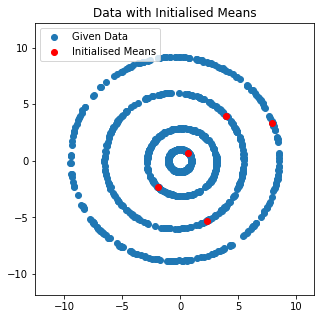

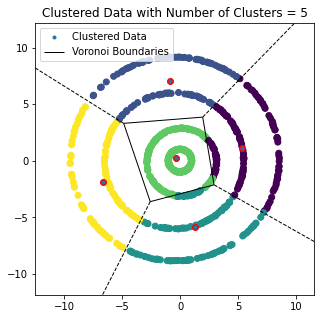

In [206]:
K = 5
mu_i = mu_random[:,:K]

_,mu,Z,_ = run_llyods(X,K=K,mu_i = mu_i)

fig1 = plt.figure()
fig1.set_size_inches(5, 5)
plt.scatter(X[0],X[1])
plt.scatter(mu_i[0],mu_i[1],color='r')
plt.xlim(*xlim_data)
plt.ylim(*ylim_data)
plt.title("Data with Initialised Means")
plt.legend(["Given Data","Initialised Means"],loc="best")

vor = Voronoi(mu.T)
fig2 = voronoi_plot_2d(vor,show_points=True,show_vertices=False)
fig2.set_size_inches(5, 5)
plt.scatter(X[0],X[1],c=Z)
plt.scatter(mu[0],mu[1],color='r')
plt.xlim(*xlim_data)
plt.ylim(*ylim_data)
plt.title("Clustered Data with Number of Clusters = 5")
plt.legend(["Clustered Data","Voronoi Boundaries"])

plt.show()

### **Q2 (iii) - Spectral Clustering**

In [215]:
def run_spectral_clustering(X_raw,num_clusters=4,sigma=1,kernel='rbf',d=2):
    X = X_raw.copy()
    n = X.shape[1]

    X = X-X.mean(axis=1).reshape(-1,1)
    K = np.zeros((n,n))
    one_N = np.ones((n,n))/n
    for i in range(n):
        for j in range(n):
            xi = X[:,i]
            xj = X[:,j]
            if kernel == "poly":
                K[i,j] = poly_kernel(xi,xj,d)
            elif kernel == 'rbf':
                K[i,j] = rbf_kernel(xi,xj,sigma)


    Kc = K - one_N@K - K@one_N + one_N@K@one_N

    w,V = np.linalg.eigh(Kc)

    H = V[:,np.flip(w.argsort())] #the columns are always the vectors
    H = H[:,:num_clusters].T
    H_star = H/np.linalg.norm(H,axis=0).reshape(-1,n)
    print("H_star generated, Running LLoyds..")
    mu_i,mu,Z,_ = run_llyods(H_star,K=4)
    return H,H_star,Z,mu,mu_i

In [240]:
def visualise_data1D(H,Z,title=''):
    plt.scatter(H[0],np.zeros(1000),c=Z)
    plt.title(title)
    plt.show()

def visualise_data2D(X,Z,title='',xlabel='',ylabel=''):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16,8, forward=True)
    fig.suptitle(title)
    ax1.scatter(X[0],X[1])

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title("Data")

    ax2.scatter(X[0],X[1],c=Z)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)
    ax2.set_title("Clustered Data with Number of Clusters = 4")
    plt.show()

def visualise_data3D(H,Z,title=""):
    fig = go.Figure(data=[go.Scatter3d(
        x=H[0],
        y=H[1],
        z=H[2],
        mode='markers',
        marker=dict(
            size=12,
            color=Z,                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )])
    fig.update_layout(title=title,title_x=0.5)
    fig.show()

In [238]:
xlabel = "Dimension 1 of the Data"
ylabel = "Dimension 2 of the Data"
title = "Spectral Clustering using RBF Kernel with sigma = "

In [261]:
H,H_star,Z,_,_ = run_spectral_clustering(X_centered,4,kernel='rbf',sigma=0.6)

H_star generated, Running LLoyds..
Number of Iterations Taken to Converge: 4


In [258]:
show_scatter_data(H_star[:,:],title="H_star matrix visualisation (Looking at 2 dimensions of the k-dim data)")

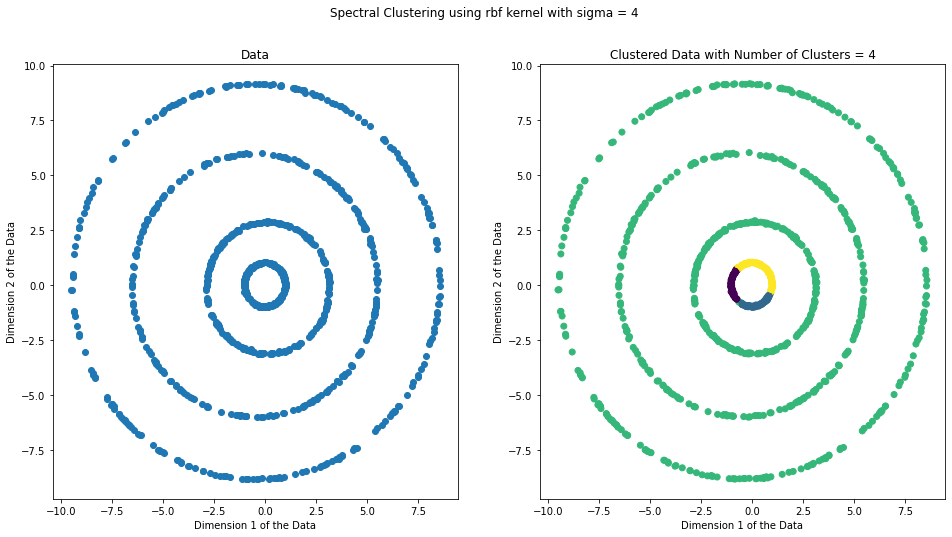

In [259]:
visualise_data2D(X_centered,Z,xlabel = "Dimension 1 of the Data",ylabel = "Dimension 2 of the Data",title="Spectral Clustering using rbf kernel with sigma = 4")

### **Q2 (iv)**

Generating the assigment vector Z directly from H_star matrix by taking arg max over the columns

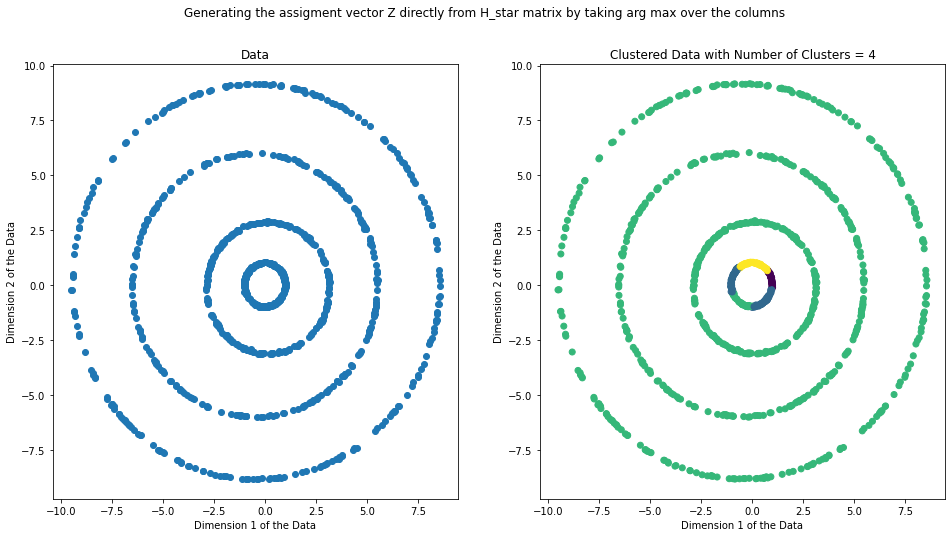

In [260]:
Z = H_star[:,:].argmax(axis=0) 
visualise_data2D(X_centered,Z,xlabel = "Dimension 1 of the Data",ylabel = "Dimension 2 of the Data",title="Generating the assigment vector Z directly from H_star matrix by taking arg max over the columns")

### **Alternate Method - Kernel PCA followed by Llyods**
In this method, only one component is taken and it happens to be linearly seperable as depicted in the 1D, 2D, 3D graphs

In [283]:
kernel_comps = get_kernel_components_rbf(X,sigma=3,num_components=3)

In [ ]:
mu_i,mu,Z,_ = run_llyods(kernel_comps[0:1],K=4)

Number of Iterations Taken to Converge: 3


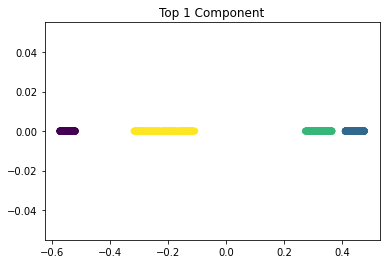

In [279]:
visualise_data1D(kernel_comps,Z,title="Top 1 Component")

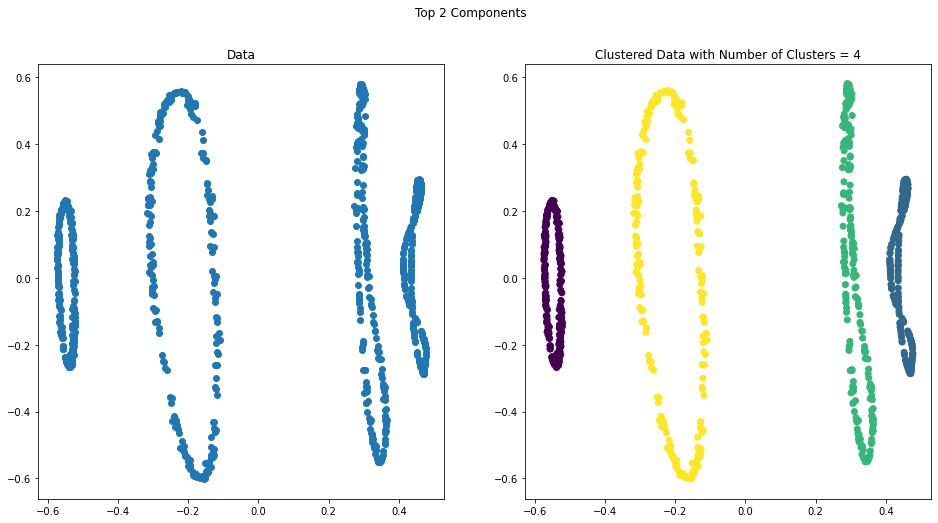

In [280]:
visualise_data2D(kernel_comps,Z,title="Top 2 Components")

In [281]:
visualise_data3D(kernel_comps,Z,title="Top 3 Components")

### **Final Results**

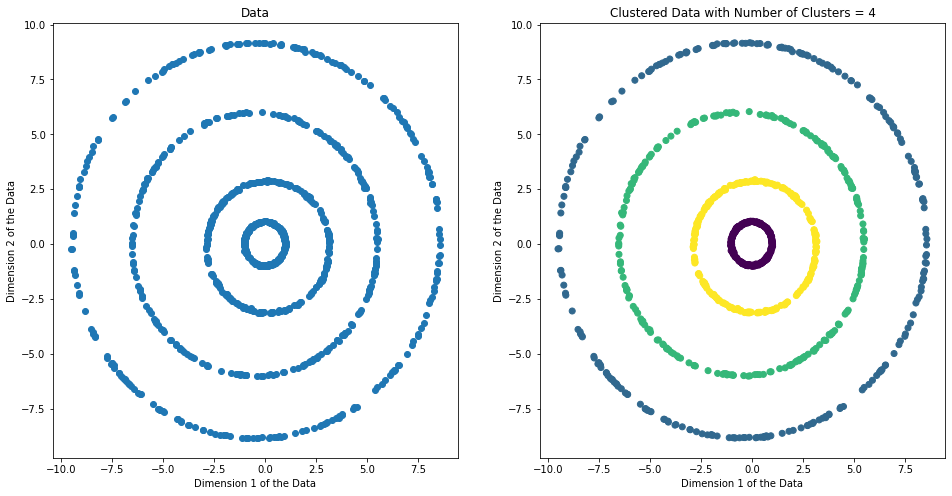

In [282]:
visualise_data2D(X_centered,Z,xlabel = "Dimension 1 of the Data",ylabel = "Dimension 2 of the Data")